In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 4)), labels=classes)
    plt.yticks(list(range(0, 4)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


In [2]:
# dataset = nlp.load_dataset('emotion')
from datasets import load_dataset
dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (C:\Users\valsa\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# train = dataset['train']
# val = dataset['validation']
# test = dataset['test']

In [4]:
dataset.set_format(type="pandas")
train = dataset["train"][:]
test = dataset["test"][:]
val = dataset["validation"][:]

In [5]:
train = train[train.label != 2]
train = train[train.label != 5]
test = test[test.label != 2]
test = test[test.label != 5]
val = val[val.label != 2]
val = val[val.label != 5]

In [6]:
def get_tweet(data):
#   tweets = [x['text'] for x in data]
#   labels = [x['label'] for x in data]
    tweets = data['text']
    labels = data['label']
    labels = labels.replace([0,1,3,4],['sadness','joy','anger','fear'])
    return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [10]:
tokenizer.texts_to_sequences([tweets[1]])

[[2,
  40,
  103,
  59,
  8,
  15,
  435,
  5,
  15,
  3798,
  498,
  31,
  59,
  60,
  125,
  156,
  77,
  1478,
  4,
  22,
  1129]]

In [11]:
tweets[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

<function matplotlib.pyplot.show(close=None, block=None)>

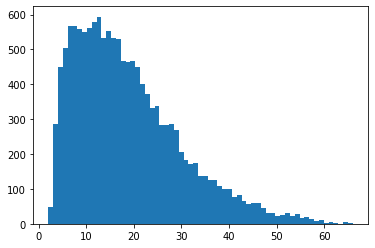

In [12]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show

In [13]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post' , padding='post', maxlen = maxlen)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [16]:
padded_train_seq

array([[   2,  137,    3, ...,    0,    0,    0],
       [   2,   40,  103, ...,    0,    0,    0],
       [  16, 3187,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  313, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]])

In [17]:
classes = set(labels)
print(classes)

{'sadness', 'anger', 'joy', 'fear'}


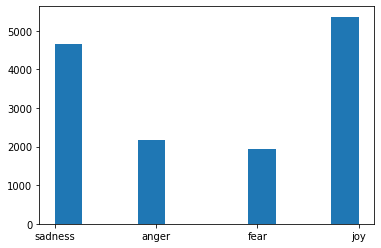

In [18]:
plt.hist(labels, bins=11)
plt.show()

In [19]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [20]:
class_to_index

{'sadness': 0, 'anger': 1, 'joy': 2, 'fear': 3}

In [21]:
index_to_class

{0: 'sadness', 1: 'anger', 2: 'joy', 3: 'fear'}

In [22]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [23]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


In [24]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [26]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [27]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [28]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
442/442 [==============================] - 15s 17ms/step - loss: 1.3065 - accuracy: 0.3913 - val_loss: 1.0676 - val_accuracy: 0.6301
Epoch 2/20
442/442 [==============================] - 6s 13ms/step - loss: 0.6761 - accuracy: 0.7525 - val_loss: 0.4344 - val_accuracy: 0.8553
Epoch 3/20
442/442 [==============================] - 6s 13ms/step - loss: 0.2237 - accuracy: 0.9320 - val_loss: 0.2566 - val_accuracy: 0.9207
Epoch 4/20
442/442 [==============================] - 6s 13ms/step - loss: 0.1189 - accuracy: 0.9657 - val_loss: 0.2686 - val_accuracy: 0.9156
Epoch 5/20
442/442 [==============================] - 6s 13ms/step - loss: 0.0737 - accuracy: 0.9792 - val_loss: 0.2754 - val_accuracy: 0.9225
Epoch 6/20
442/442 [==============================] - 6s 13ms/step - loss: 0.0512 - accuracy: 0.9865 - val_loss: 0.2757 - val_accuracy: 0.9305
Epoch 7/20
442/442 [==============================] - 6s 13ms/step - loss: 0.0440 - accuracy: 0.9879 - val_loss: 0.3251 - val_accuracy: 0.919

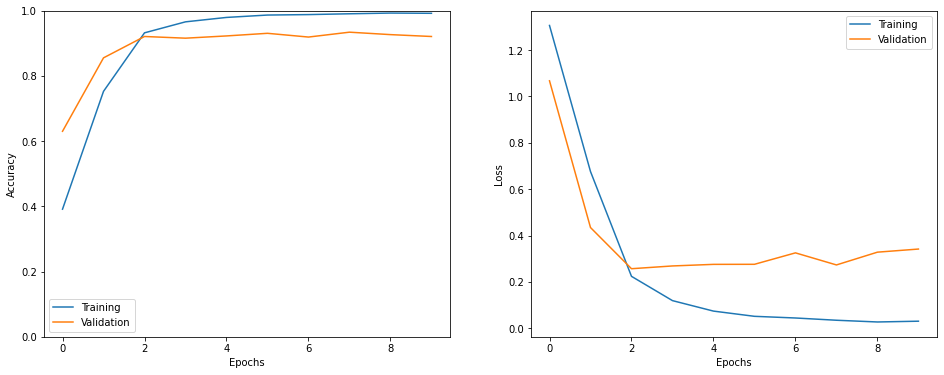

In [29]:
show_history(h)

In [30]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [31]:
_=model.evaluate(test_seq, test_labels)

56/56 [==============================] - 1s 11ms/step - loss: 0.3176 - accuracy: 0.9194


In [32]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i am feeling a bit ungrateful and choose to correct that
Emotion: joy
Predicted Emotion: joy


In [33]:
preds = np.argmax(model.predict(test_seq), axis=-1)

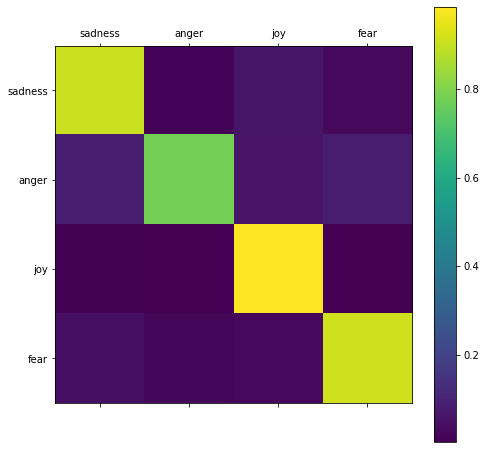

In [34]:
show_confusion_matrix(test_labels, preds, list(classes))